In this notebook, we investigate the impact of sample correlation on the error estimate of the free energy profile built in ThermoLIB. We also consider various alternative ways of constructing free energy profiles and estimating error bars and compare the results at the end. Herein, we will illustrate the routine ``decorrelate`` from the ThermoLIB tools allows for adequate error estimations.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from thermolib.thermodynamics.fep import SimpleFreeEnergyProfile, plot_profiles
from thermolib.thermodynamics.histogram import Histogram1D
from thermolib.tools import read_wham_input, blav, decorrelate, corrtime_from_acf
from thermolib.thermodynamics.trajectory import ColVarReader

import numpy as np, matplotlib.pyplot as pp

from molmod.units import *

In [3]:
prefix = 'advanced_wham1D_error_'

# Impact MD correlation on WHAM reconstuction

In this section, we illustrate the impact of correlation between subsequent samples in the MD trajectories. To that end, we apply a regular WHAM procedure to all biased simulation data defined in data/wham_input.txt using all trajectory samples, as well as using only a sample every 10/100/1000 steps.

In [4]:
bins = np.arange(-1.6, 1.6, 0.02)
fn_meta = 'data/formic_acid_dimer_link/wham_input.txt'

In [5]:
colvar_reader_1 = ColVarReader([0], units=['au'])
temp, biasses, trajectories_1 = read_wham_input(
    fn_meta, colvar_reader_1, 'trajectories_correlated/COLVAR_%s.dat', 
    bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
)
hist_1 = Histogram1D.from_wham(bins, trajectories_1, biasses, temp, error_estimate='mle_f', Nscf=10000)
fep_1 = SimpleFreeEnergyProfile.from_histogram(hist_1, temp=temp)

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 01.511s
  bias poten. : 00h 00m 00.018s
  solve scf   : 00h 00m 00.424s
  error est.  : 00h 00m 00.036s
  TOTAL       : 00h 00m 01.991s
---------------------------------------------------------------------


In [6]:
colvar_reader_10 = ColVarReader([0], stride=10 ,units=['au'])
temp, biasses, trajectories_10 = read_wham_input(
    fn_meta, colvar_reader_10, 'trajectories_correlated/COLVAR_%s.dat', 
    bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
)
hist_10 = Histogram1D.from_wham(bins, trajectories_10, biasses, temp, error_estimate='mle_f', Nscf=10000)
fep_10 = SimpleFreeEnergyProfile.from_histogram(hist_10, temp=temp)

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.149s
  bias poten. : 00h 00m 00.038s
  solve scf   : 00h 00m 00.362s
  error est.  : 00h 00m 00.225s
  TOTAL       : 00h 00m 00.774s
---------------------------------------------------------------------


In [7]:
colvar_reader_100 = ColVarReader([0], stride=100 ,units=['au'])
temp, biasses, trajectories_100 = read_wham_input(
    fn_meta, colvar_reader_100, 'trajectories_correlated/COLVAR_%s.dat', 
    bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
)
hist_100 = Histogram1D.from_wham(bins, trajectories_100, biasses, temp, error_estimate='mle_f', Nscf=10000)
fep_100 = SimpleFreeEnergyProfile.from_histogram(hist_100, temp=temp)

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.016s
  bias poten. : 00h 00m 00.019s
  solve scf   : 00h 00m 00.871s
  error est.  : 00h 00m 00.043s
  TOTAL       : 00h 00m 00.950s
---------------------------------------------------------------------


In [8]:
colvar_reader_1000 = ColVarReader([0], stride=1000 ,units=['au'])
temp, biasses, trajectories_1000 = read_wham_input(
    fn_meta, colvar_reader_1000, 'trajectories_correlated/COLVAR_%s.dat', 
    bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
)
hist_1000 = Histogram1D.from_wham(bins, trajectories_1000, biasses, temp, error_estimate='mle_f', Nscf=10000)
fep_1000 = SimpleFreeEnergyProfile.from_histogram(hist_1000, temp=temp)

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.005s
  bias poten. : 00h 00m 00.016s
  solve scf   : 00h 00m 01.026s
  error est.  : 00h 00m 00.036s
  TOTAL       : 00h 00m 01.083s
---------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


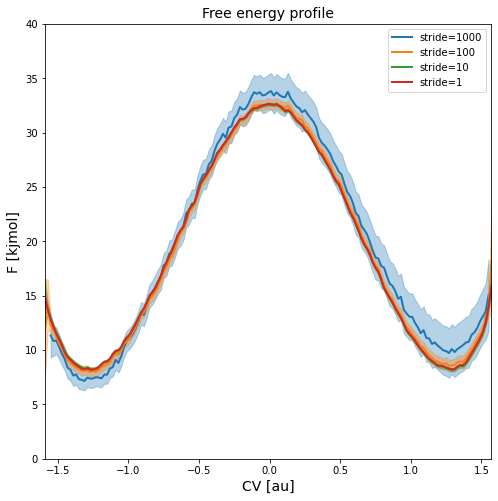

In [9]:
plot_profiles([fep_1000,fep_100,fep_10,fep_1], labels=['stride=1000', 'stride=100', 'stride=10', 'stride=1'], flims=[0,40])

# Estimating the autocorrelation time

The plot above indicates that the error becomes larger as the stride increases (which is logical as it gives WHAM a lot less data to work with). However, the question now is which is the most reliable representation of the error. To that end, we estimate the correlation time from the autocorrelation function of the collective variable itself during the trajectories. We first illustrate this for a few individual trajectories:

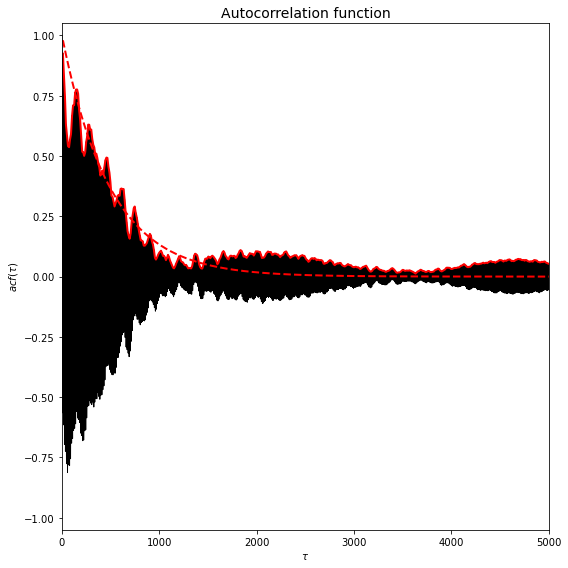

Correlation time = 990.081 timesteps


In [10]:
corrtime = corrtime_from_acf(trajectories_1[8], plot=True, xlims=[0,5000], ylims=[-1.05,1.05])
print('Correlation time = %.3f timesteps' %corrtime)

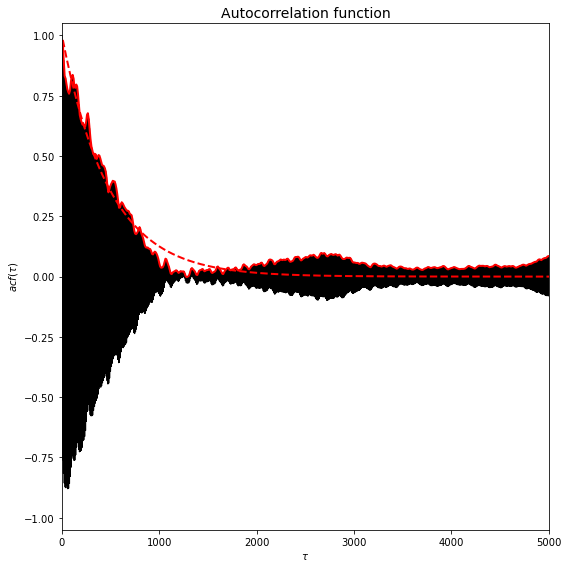

Correlation time = 961.006 timesteps


In [11]:
corrtime = corrtime_from_acf(trajectories_1[17], plot=True, xlims=[0,5000], ylims=[-1.05,1.05])
print('Correlation time = %.3f timesteps' %corrtime)

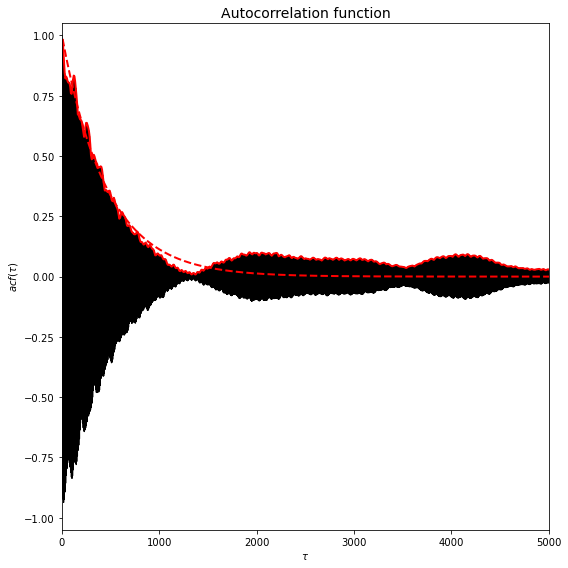

Correlation time = 916.428 timesteps


In [12]:
corrtime = corrtime_from_acf(trajectories_1[64], plot=True, xlims=[0,5000], ylims=[-1.05,1.05])
print('Correlation time = %.3f timesteps' %corrtime)

Let us now compute the correlation time for each trajectory and decorrelate the trajectories by averaging over blocks with length given by the correlation time. This is implemented in the `decorrelate` routine.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

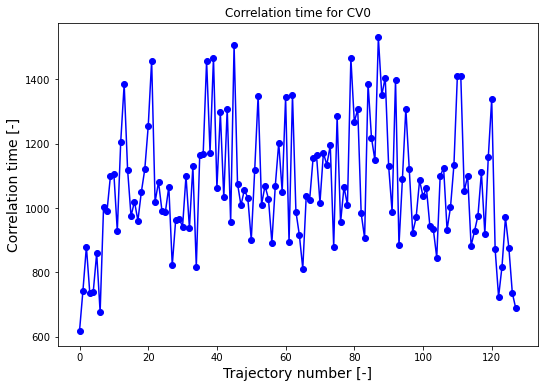

In [13]:
corrtimes = decorrelate(trajectories_1, plot=True)

The above routine returns the correlation times for each simulation (i.e. each umbrella) as well as the 'decorrelated' trajectories. This latter quantity represents the original trajectory data but post-processed with a rolling average with a time-width given by the corresponding correlation time. In this way, it extracts only the statistically indepedent samples. This decorrelated trajectory could be used to make an estimate of the error bar in the `from_wham` routine. However, as the error estimation is based on the Fisher information matrix of the maximum likelihood estimator, we can reconstruct the free energy profile using all original samples, but now we also parse the correlation times to the `from_wham` routine to obtain a more reliable error estimation by accounting for the reduced information due to correlation (i.e. only N/corrtime independent samples) in the information matrix:

In [15]:
hist_decor = Histogram1D.from_wham(bins, trajectories_1, biasses, temp, error_estimate='mle_f', corrtimes=corrtimes, Nscf=10000)
fep_decor = SimpleFreeEnergyProfile.from_histogram(hist_decor, temp=temp)
#fep_decor.set_ref(ref='min')

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 01.524s
  bias poten. : 00h 00m 00.014s
  solve scf   : 00h 00m 00.425s
  error est.  : 00h 00m 00.032s
  TOTAL       : 00h 00m 01.996s
---------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

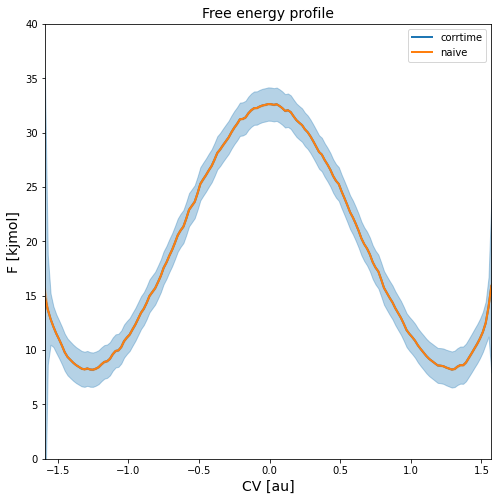

In [16]:
plot_profiles([fep_decor,fep_1], labels=['corrtime', 'naive'], flims=[0,40])

# Evaluating the error estimation

In order to test the above error estimation, we are now going to generate profiles from various sources of subsets of the original trajectories and investigate whether the WHAM profile generated by each subset indeed falls within the predicted error bar. The various methods for generating subsets of data are:

1) Delayed-strided profiles
2) Blocked profiles
3) Bootstrapped profiles

## Delayed-strided WHAM profiles

In [17]:
starts = np.arange(0,1000,100)
feps = []
for start in starts:
    print("Constructing WHAM FEP for start=%i" %start)
    colvar_reader = ColVarReader([0], units=['au'], start=start, stride=1000)
    temp, biasses, trajectories = read_wham_input(
        fn_meta, colvar_reader, 'trajectories_correlated/COLVAR_%s.dat', 
        bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
    )    
    hist = Histogram1D.from_wham(bins, trajectories, biasses, temp, Nscf=10000)
    fep = SimpleFreeEnergyProfile.from_histogram(hist, temp)
    #fep.set_ref(ref='min')
    feps.append(fep)

Constructing WHAM FEP for start=0
SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.005s
  bias poten. : 00h 00m 00.014s
  solve scf   : 00h 00m 00.998s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 01.018s
---------------------------------------------------------------------
Constructing WHAM FEP for start=100
SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.005s
  bias poten. : 00h 00m 00.018s
  solve scf   : 00h 00m 00.952s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 00.976s
---------------------------------------------------------------------
Constructing WHAM FEP for start=200
SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.005s
  bias

<Figure size 432x288 with 0 Axes>

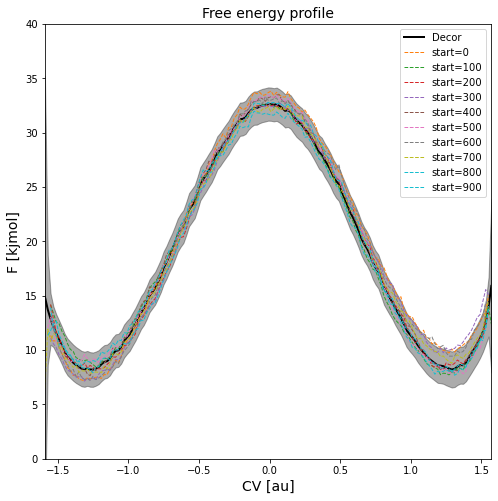

In [18]:
fep_delstr = SimpleFreeEnergyProfile.from_average(feps, error_estimate='std')
plot_profiles([fep_decor]+feps, labels=['Decor']+['start=%i' %start for start in starts], flims=[0,40],
               colors    =['k']+[None,]*len(starts),
               linewidths=[2  ]+[1   ,]*len(starts),
               linestyles=['-']+['--',]*len(starts))

All profiles indeed fall within the predicted 2-sigma error bar.

## Blocked WHAM profiles

We now devide the original data in 10 subsequent blocks and compute the WHAM FEP for each block

In [19]:
nblocks = 10
blocksize = int(min([len(traj) for traj in trajectories_1])/nblocks)
feps2 = []
labels2 = []
for iblock in range(nblocks):
    start, end = iblock*blocksize, (iblock+1)*blocksize
    print("Constructing histogram for block [%i,%i]" %(start,end))
    colvar_reader = ColVarReader([0], units=['au'], start=start, end=end, stride=1)
    temp, biasses, trajectories = read_wham_input(
        fn_meta, colvar_reader, 'trajectories_correlated/COLVAR_%s.dat', 
        bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
    )
    hist = Histogram1D.from_wham(bins, trajectories, biasses, temp)
    fep = SimpleFreeEnergyProfile.from_histogram(hist, temp)
    #fep.set_ref(ref='min')
    feps2.append(fep)
    labels2.append("Block[%i,%i]"%(start,end))

Constructing histogram for block [0,20000]
SCF did not converge!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.175s
  bias poten. : 00h 00m 00.022s
  solve scf   : 00h 00m 00.138s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 00.337s
---------------------------------------------------------------------
Constructing histogram for block [20000,40000]
SCF did not converge!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.128s
  bias poten. : 00h 00m 00.016s
  solve scf   : 00h 00m 00.123s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 00.268s
---------------------------------------------------------------------
Constructing histogram for block [40000,60000]
SCF did not converge!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00

<Figure size 432x288 with 0 Axes>

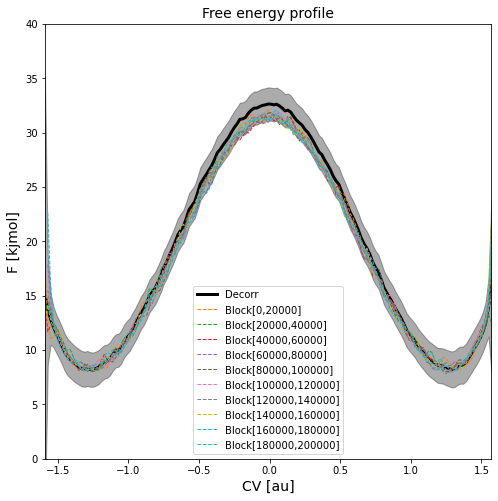

In [20]:
fep_block = SimpleFreeEnergyProfile.from_average(feps2, error_estimate='std')
plot_profiles([fep_decor]+feps2, labels=['Decorr']+labels2, flims=[0,40], 
                colors    =['k']+[None,]*nblocks, 
                linestyles=['-']+['--',]*nblocks, 
                linewidths=[3  ]+[1   ,]*nblocks)

Again all profiles are within the predicted 2-sigma error bar.

## Bootstrapped WHAM profiles

Finally, we again reconstruct various FEPS, but know using bootstrapping applied to each of the original biased simulations. Again, we consider 10 trajectories.

In [21]:
Nboot = 10
feps3 = []
for iboot in range(Nboot):
    new_trajectories = []
    for traj in trajectories_1:
        Nsteps = len(traj)
        indices = np.random.randint(0, high=Nsteps, size=int(Nsteps/Nboot))
        new_trajectories.append(traj[indices]) 
    hist = Histogram1D.from_wham(bins, new_trajectories, biasses, temp, Nscf=10000)
    fep = SimpleFreeEnergyProfile.from_histogram(hist, temp)
    #fep.set_ref(ref='min')
    feps3.append(fep)

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.141s
  bias poten. : 00h 00m 00.015s
  solve scf   : 00h 00m 00.330s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 00.487s
---------------------------------------------------------------------
SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.135s
  bias poten. : 00h 00m 00.013s
  solve scf   : 00h 00m 00.467s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 00.616s
---------------------------------------------------------------------
SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.128s
  bias poten. : 00h 00m 00.012s
  solve scf   : 00h 00m 00.295s
  error est.  : 00h 00m 00.000s
  TOTAL       : 

<Figure size 432x288 with 0 Axes>

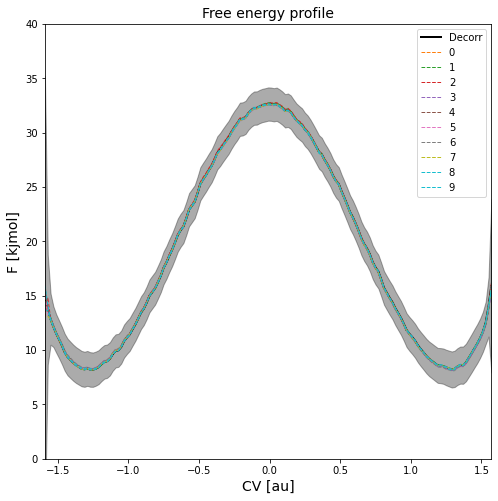

In [22]:
fep_boot = SimpleFreeEnergyProfile.from_average(feps3, error_estimate='std')
plot_profiles([fep_decor]+feps3, labels=['Decorr']+['%i' %i for i in np.arange(0,10,1)], flims=[0,40],
               colors    =['k']+[None,]*10,
               linewidths=[2  ]+[1   ,]*10,
               linestyles=['-']+['--',]*10)

# Covariance between different points on FEP

It is important to realize that the free energy at $q_1$ is not independent from the free energy at $q_2$. This is not only the case for close neighbors (large positive correlation), but in the present case of a profile with two equistable minima, also between points from these equistable minima (i.e. reactant and product state). The main reason for this the fact that the free energy is derived from a normalized probability and this normalization introduces a strong negative correlation between these two equistable minima, because decreased free energy (i.e. increased probability) for reactant implies increased free energy (i.e. decreased probality) for product. 

To illustrate the importance of this, we first plot samples of the full free energy profile according to 'uncorrelated' error bars and show the difference with the scenario where we redo the error estimation with explicit covariance using `error_estimate=mle_f_cov`.

Considering first the free energy profile without covariance, we can plot samples using the plot routine as follows:

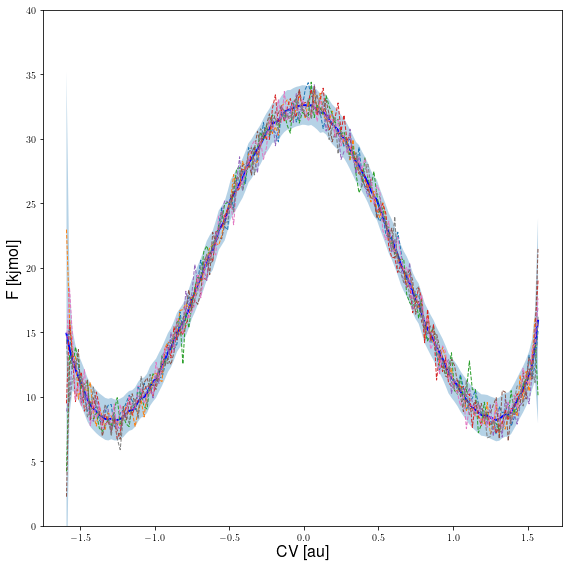

In [26]:
fep_decor.plot(
    obss      =['error-mean']+['error-sample',]*8,
    linestyles=         ['-']+          ['--',]*8,
    linewidths=           [2]+             [1,]*8,
    colors    =         ['b']+          [None,]*8,
    flims=[0,40]
)

As we can see, the error just corresponds to normally random fluctuations on all points individually without any correlation between fluctuations.

We now reconstruct the error on the fep by explicitly taking the covariance into account.

In [27]:
hist_cov = Histogram1D.from_wham(bins, trajectories_1, biasses, temp, error_estimate='mle_f_cov', corrtimes=corrtimes, Nscf=10000)
fep_cov = SimpleFreeEnergyProfile.from_histogram(hist_cov, temp, cv_output_unit='au', cv_label='CV', f_output_unit='kjmol')
fep_cov.process_states(lims=[-1.5,-0.2,0.2,1.5])

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 01.497s
  bias poten. : 00h 00m 00.016s
  solve scf   : 00h 00m 00.463s
  error est.  : 00h 00m 00.082s
  TOTAL       : 00h 00m 02.059s
---------------------------------------------------------------------


As can be seen in the free energy profile below, the 2-sigma error bar on the entire profile is identical with or without accounting for covariance:

<Figure size 432x288 with 0 Axes>

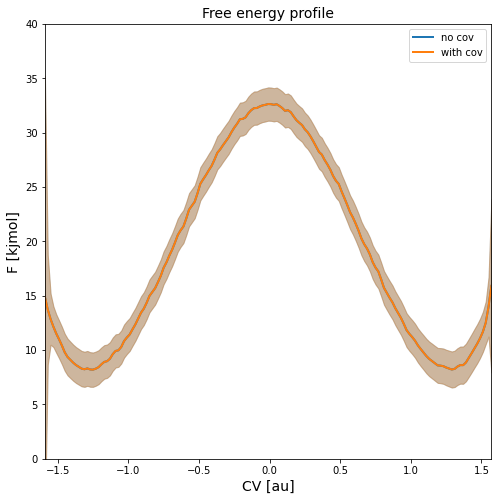

In [28]:
plot_profiles([fep_decor,fep_cov], labels=['no cov', 'with cov'], flims=[0,40])

However, the coviarance is clearly non neglible as seen in the matrix plot below of the correlation matrix between the various points on the fep. This correlation ranges from 1 (perfect correlation), to 0 (completely uncorrelated) and -1 (perfect anticorrelation).

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

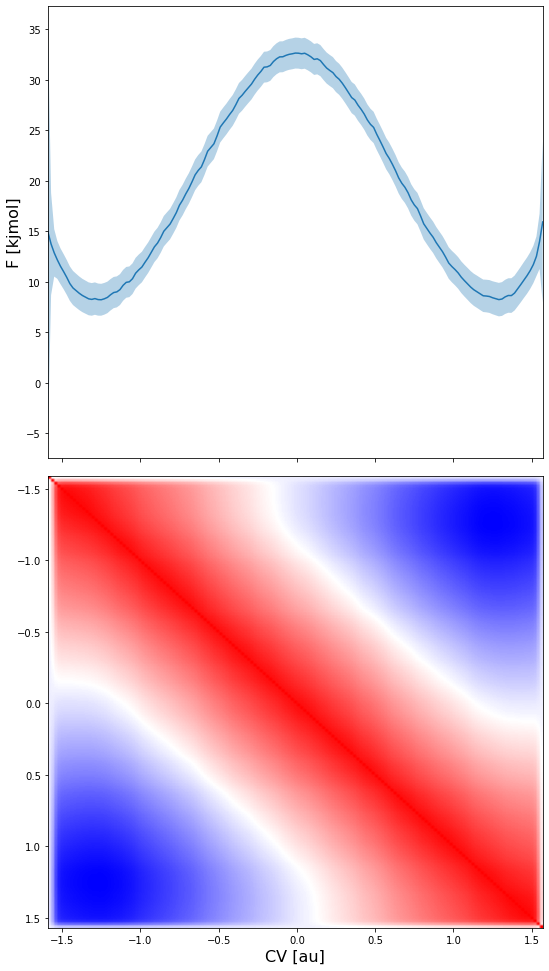

In [29]:
fep_cov.plot_corr_matrix()

Therefore, the error model in fep_cov generates much more reliable 'samples' of the full free energy profile by taking into account the full covariance matrix. This can again be plotted using the `fep_cov.plot_samples` routine:

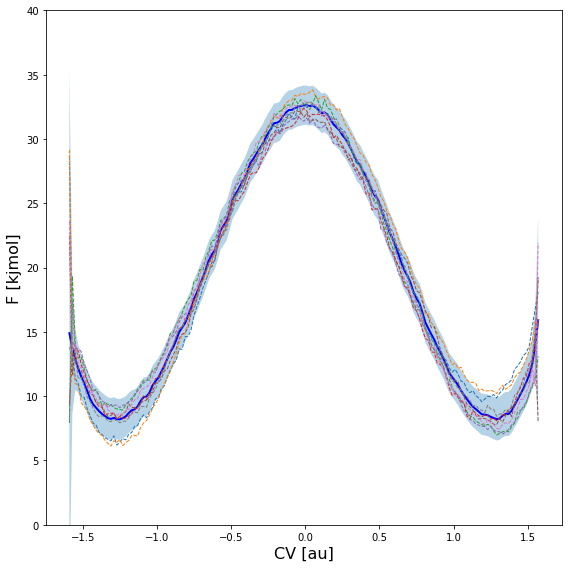

In [30]:
fep_cov.plot(
    obss      =['error-mean']+['error-sample',]*8,
    linestyles=         ['-']+          ['--',]*8,
    linewidths=           [2]+             [1,]*8,
    colors    =         ['b']+          [None,]*8,
    flims=[0,40]
)

This figure clearly illustrates that higher free energy for reactant state also implies lower free energy for the product state and vice versa! Such correlated estimates of samples of the full free energy profile allows to do proper error propagation, i.e. to compute the free energy of integrated macrostates. To illustrate that, we compute propagate the error on the profile to that on the microstate/macrostate free energy derived from the profile for both the fep without covariance (i.e. fep_decor) and that with covariance estimate (i.e. fep_cov):

In [31]:
fep_decor.process_states(lims=[-1.5,-0.5,0.5,1.5], verbose=True)

MICROSTATE ts:
--------------
  index =  None
  F     = 33.755 +- 0.888 kjmol
  CV    = 0.014 +- 0.152 au

MICROSTATE r:
--------------
  index =  None
  F     = 7.125 +- 0.878 kjmol
  CV    = -1.285 +- 0.146 au

MICROSTATE p:
--------------
  index =  None
  F     = 7.161 +- 0.969 kjmol
  CV    = 1.280 +- 0.127 au

MACROSTATE R:
--------------
  F       = 10.404 +- 0.355 kjmol
  CV Mean = -1.236 +- 0.015 au
  CV StD  = 0.147 +- 0.009 au

MACROSTATE P:
--------------
  F       = 10.441 +- 0.342 kjmol
  CV Mean = 1.232 +- 0.016 au
  CV StD  = 0.144 +- 0.009 au



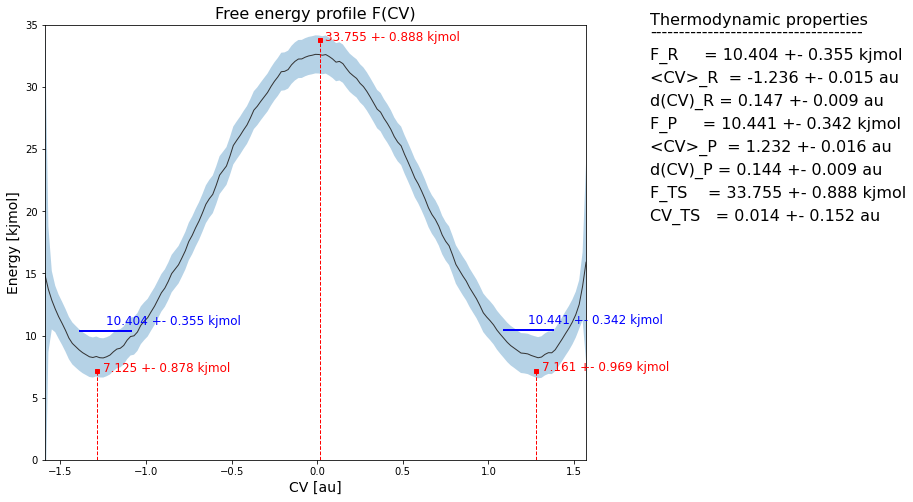

In [32]:
fep_decor.plot(flims=[0,35])

Here, we clearly see that estimate of the red microstate dots representing local minima (reactant ant product) and maxima (transition state) are located on the lower/upper edge of the error bar respectively. That is because in the random samples of the full fep, the lack of correlation between neighboring points (which results in uncorrelated fluctuation on the free energy of each point) ensures that there will always be a point close to the lower/upper error bar boundary. Furthermore, we also see a much lower error on the blue macrostates representing the integral over reactant (left of ts) and product (right of ts) microstates. This is because the random fluctuation resulting the uncorrelated error bar is moslty filtered out by the integral.

This clearly indicates the failure of uncorrelated error bars for propagation towards derived properties. Instead, we need to do such error propagation using correlated error bars coming from accounting for the full covariance matrix.

In [33]:
fep_cov.process_states(lims=[-1.5,-0.5,0.5,1.5], verbose=True)

MICROSTATE ts:
--------------
  index =  None
  F     = 32.951 +- 1.387 kjmol
  CV    = 0.004 +- 0.078 au

MICROSTATE r:
--------------
  index =  None
  F     = 7.964 +- 1.546 kjmol
  CV    = -1.269 +- 0.088 au

MICROSTATE p:
--------------
  index =  None
  F     = 7.955 +- 1.575 kjmol
  CV    = 1.280 +- 0.088 au

MACROSTATE R:
--------------
  F       = 10.326 +- 1.464 kjmol
  CV Mean = -1.236 +- 0.025 au
  CV StD  = 0.146 +- 0.011 au

MACROSTATE P:
--------------
  F       = 10.297 +- 1.104 kjmol
  CV Mean = 1.233 +- 0.025 au
  CV StD  = 0.145 +- 0.011 au



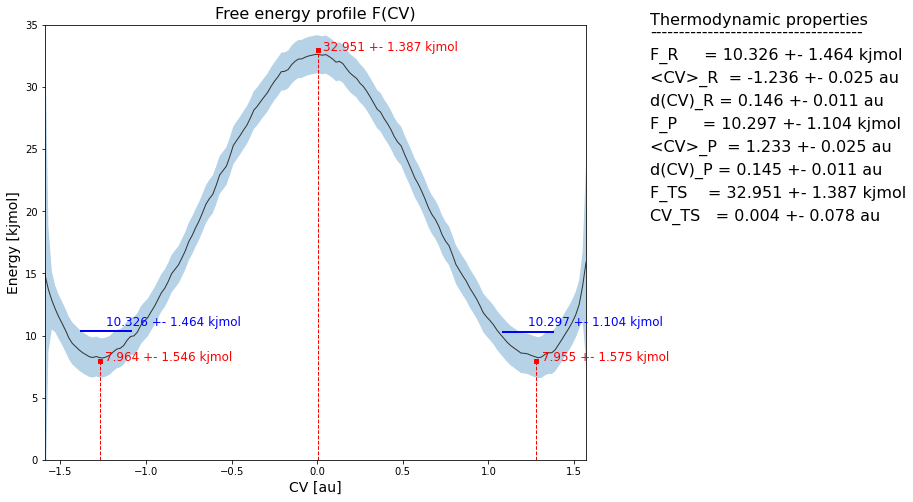

In [34]:
fep_cov.plot(flims=[0,35])